# Смотрим на данные

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
import os

In [ ]:
drive.mount('/content/gdrive')
url = os.chdir(r"/content/gdrive/MyDrive")
os.getcwd()

Mounted at /content/gdrive


'/content/gdrive/MyDrive'

In [ ]:
os.chdir(r"/content/gdrive/MyDrive/signal-types")

In [ ]:
# Data loading

dataset = pd.read_csv('Run200_Wave_0_1.txt', sep=' ', header=None, skipinitialspace=True)
dataset = dataset.drop([0, 1, 2, 3, 504], axis=1)
dataset.columns = list(range(500))
dataset.head()


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,14820,14823,14824,14822,14818,14820,14824,14822,14820,14820,...,14828,14822,14815,14815,14817,14819,14820,14822,14820,14819
1,14820,14822,14820,14826,14824,14822,14820,14822,14823,14821,...,14828,14817,14824,14822,14824,14819,14820,14819,14822,14820
2,14820,14820,14822,14825,14820,14824,14824,14819,14823,14824,...,14820,14821,14820,14820,14818,14821,14823,14820,14820,14821
3,14828,14822,14818,14824,14824,14822,14820,14822,14824,14820,...,14824,14826,14822,14821,14820,14828,14820,14822,14823,14822
4,14823,14815,14823,14821,14827,14820,14823,14824,14816,14821,...,14820,14820,14823,14828,14824,14820,14824,14824,14822,14825


In [ ]:
dataset.shape

(23479, 500)

Text(0, 0.5, 'bit ADC')

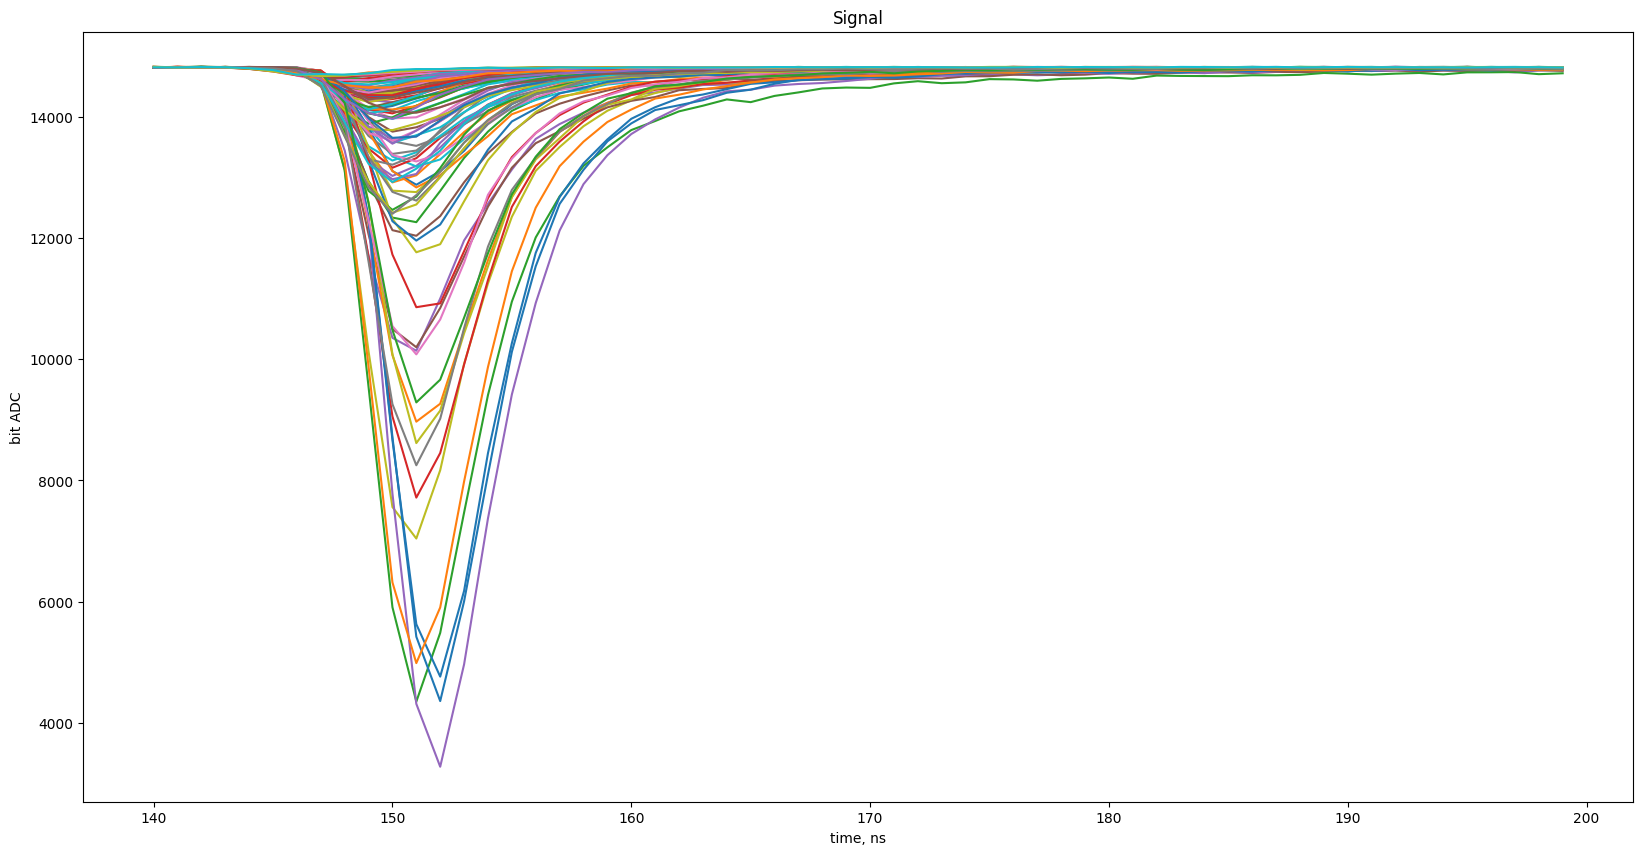

In [ ]:
N=range(0,100)
ax = dataset.T[N][140:200].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")

Text(0, 0.5, 'bit ADC')

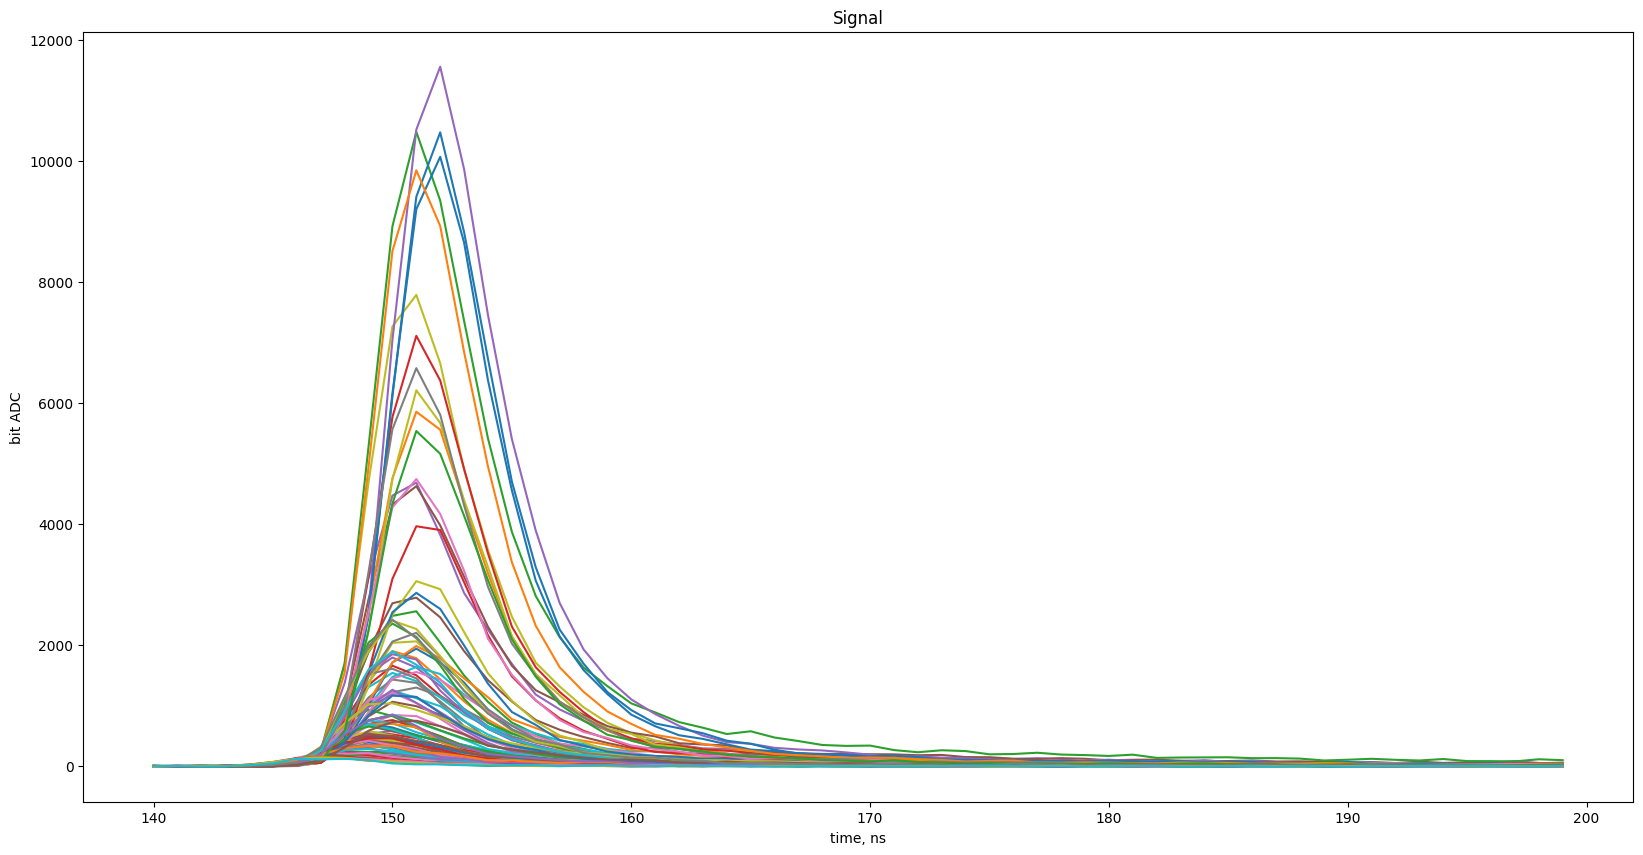

In [ ]:
ax = (2**14-dataset.T[N]-1560)[140:200].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")


In [ ]:
signals = (2**14-dataset.T-1560)[140:200].to_numpy()
signals = np.swapaxes(signals, 0, 1)
signals.shape

(23479, 60)

# Метод главных компонент

In [ ]:
def trapeze(x, y):
  area = 0
  for i in range(len(x)-1):
    area += (x[i+1]-x[i]) * (y[i+1]+y[i]) / 2
  return area

In [ ]:
areas = []

for i in range(23479):
  y = np.array((2**14-dataset.T[i]-1560)[140:200])
  x = np.array(range(len(y)))
  area = trapeze(x, y)
  areas.append(area)

In [ ]:
amps =  dataset.max(axis=1) - dataset.min(axis=1)
amps = np.array(amps)
areas = np.array(areas)

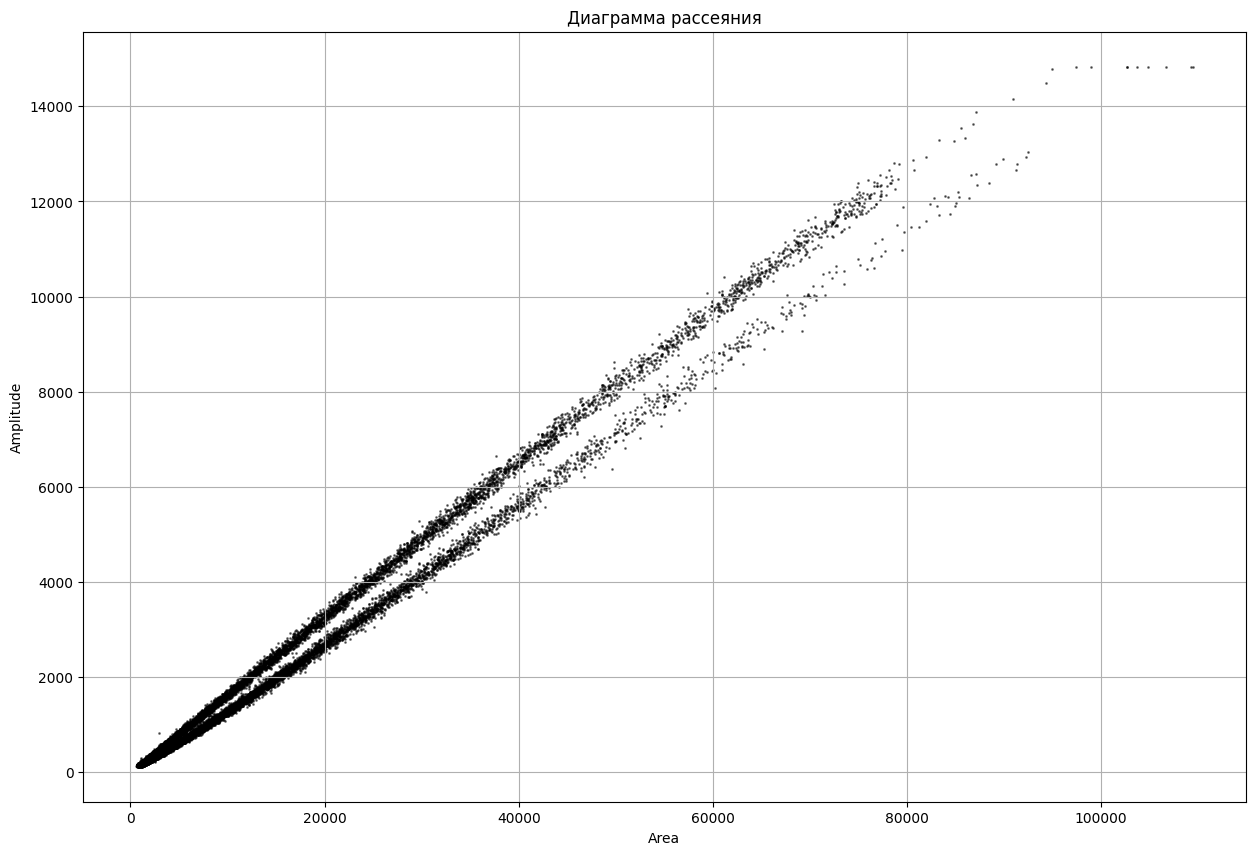

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(areas, amps, s=1, c='black', marker='o', alpha=0.5)
plt.xlabel("Area")
plt.ylabel("Amplitude")
plt.title(f'Диаграмма рассеяния')

plt.grid()
plt.show()

In [ ]:
areas = areas.reshape(-1, 1)
amps = amps.reshape(-1, 1)

print((areas).shape)
print((amps).shape)

(23479, 1)
(23479, 1)


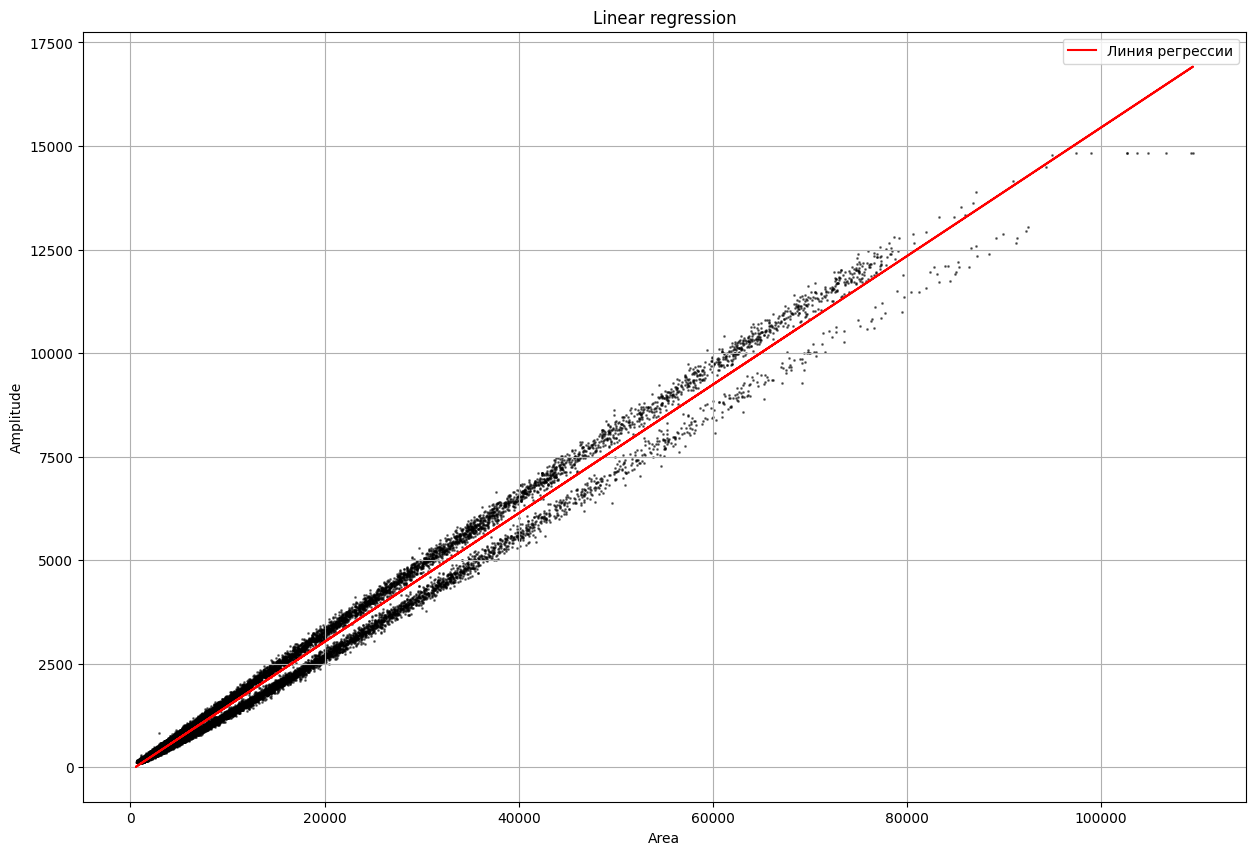

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(areas, amps)

line = model.predict(areas)

plt.figure(figsize=(15,10))

plt.scatter(areas, amps, s=1, c='black', marker='o', alpha=0.5)


plt.plot(areas, line, label='Линия регрессии', color='red')

plt.xlabel('Area')
plt.ylabel('Amplitude')
plt.title('Linear regression')
plt.legend()
plt.grid()
plt.show()

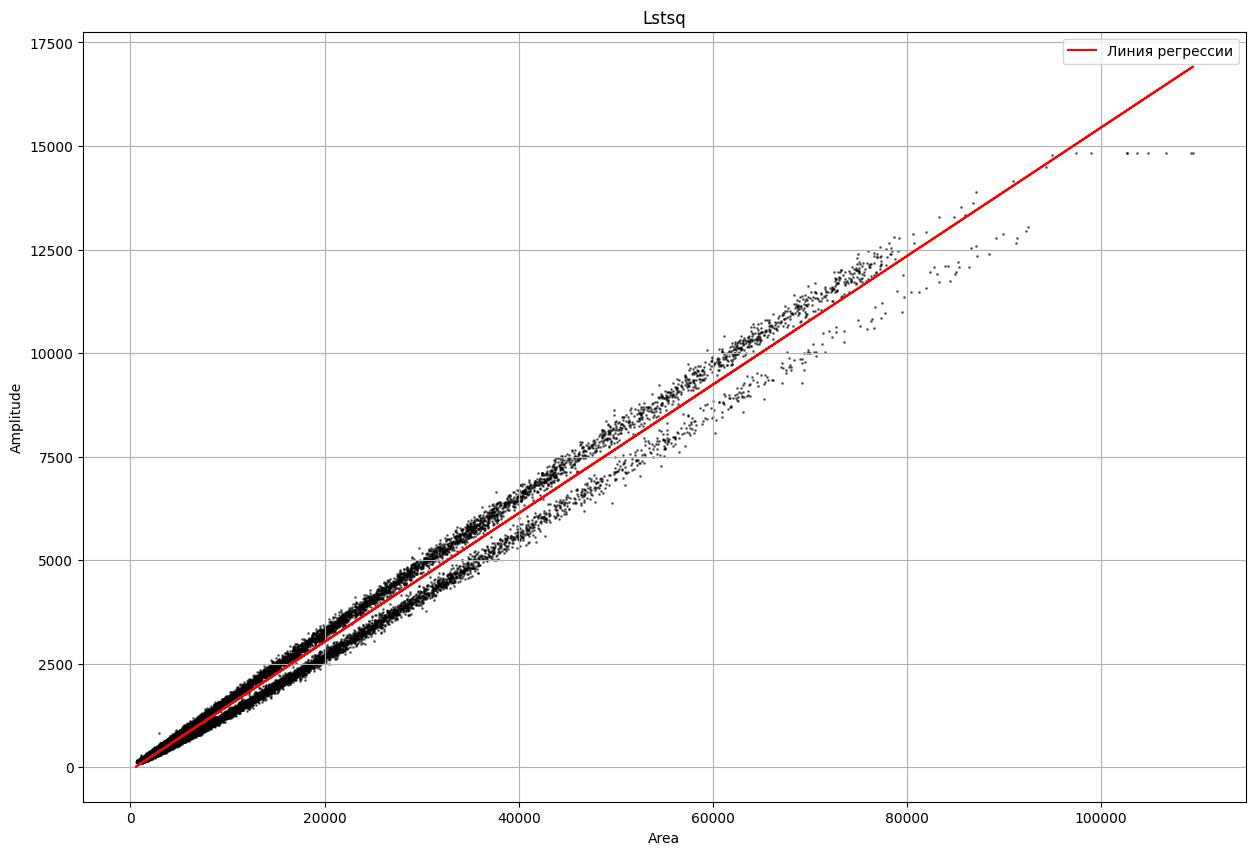

In [ ]:
A = np.vstack([areas.T, np.ones(len(areas))]).T
b = amps

x_hat, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)


plt.figure(figsize=(15,10))

plt.scatter(areas, amps, s=1, c='black', marker='o', alpha=0.5)

y_fit = A @ x_hat
plt.plot(areas, y_fit, label='Линия регрессии', color='red')

# Настройка графика
plt.xlabel('Area')
plt.ylabel('Amplitude')
plt.title('Lstsq')
plt.legend()
plt.grid()
plt.show()

Вроде одно и то же вышло

In [ ]:
pred_0 = (amps > line).astype(int) # индексы 0 класса
pred_1 = (amps < line).astype(int) # индексы 1 класса

line_labels = pred_1 # лэйблы при таком способе разделения

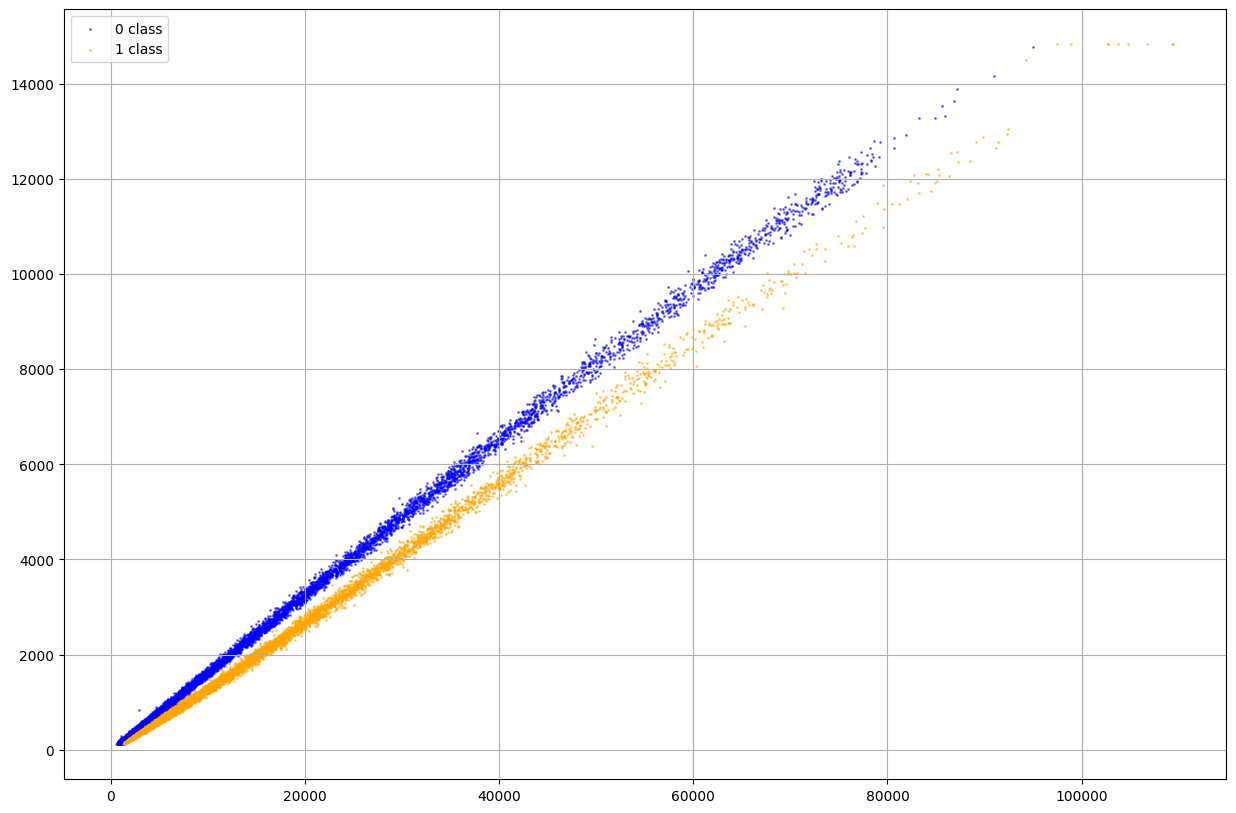

In [ ]:
plt.figure(figsize=(15,10))

plt.scatter(areas[pred_0 == 1], amps[pred_0 == 1], s=1, label='0 class', c='blue', marker='o', alpha=0.5)

plt.scatter(areas[pred_1 == 1], amps[pred_1 == 1], s=1, label='1 class', c='orange', marker='o', alpha=0.5)

plt.grid()
plt.legend()
plt.show()

Вот такие классы получились, у 0 индекс 0, у 1 индекс 1, разделили по линии

# Время высвечивания (не получилось)

Тут я очень сильно пыталась посчитать время высвечивания, то есть коэффициент в показателе более медленно убывающей экспоненты из двух, суммой которых мы апроксимируем наш сигнал. Как я поняла, надо рассматривать только тот кусок, где сигнал уже уменьшается. Но поскольку в методичке не было написано, какие именно параметры у этих экспонент мы задаем, смещения и так далее. Эта шутка она вот визуально похожа на экспоненту, но в рельности ею не апроксимируется.... я не знаю почему 😢

In [ ]:
from scipy.optimize import curve_fit

def exp_func(t, u1, u2, tau1, tau2, b):
    return u1*np.exp(-t/tau1) + u2*np.exp(-t/tau2) + b

def decay_time(signal, time): # время высвечивания
  max_index = np.argmax(signal)
  after_max_s = signal[max_index + 1:]
  after_max_t = time[max_index + 1:]

  params, covariance = curve_fit(exp_func, after_max_t, after_max_s)

  u1_fit, u2_fit, tau1_fit, tau2_fit, b_fit = params

  return params

In [ ]:
decay_times = []

time = np.arange(140, 200, 1)

for signal in signals:
  u1_fit, u2_fit, tau1_fit, tau2_fit, b_fit = decay_time(signal, time)
  decay_times.append(min(tau2_fit, tau1_fit))


<ipython-input-19-7c2c5d1df0aa>:11: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(exp_func, after_max_t, after_max_s)


<ipython-input-19-7c2c5d1df0aa>:11: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(exp_func, after_max_t, after_max_s)


9
[ 1.    1.    1.    1.   56.62]


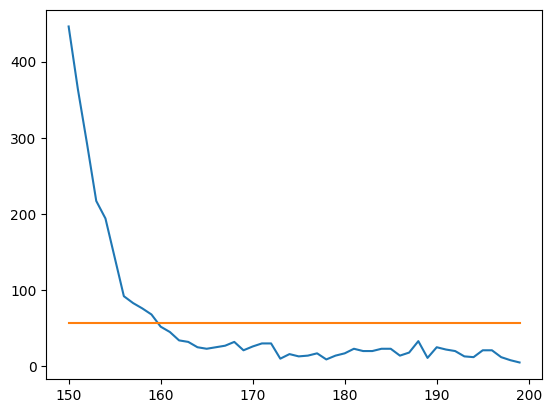

In [ ]:
max_index0 = np.argmax(signals[0])
plt.plot(time[max_index0 + 1:], signals[0][max_index0 + 1:])
u1_0, u2_0, tau1_0, tau2_0, b_0 = decay_time(signals[0], time)
plt.plot(time[max_index0 + 1:], u1_0*np.exp(-time[max_index0 + 1:]/tau1_0) + u2_0*np.exp(- time[max_index0 + 1:]/tau2_0) + b_0)
print(np.argmax(signals[0]))
print(decay_time(signals[0], time))

In [ ]:
signals[0]

array([  6,   1,   6,   6,   4,  10,  61, 261, 446, 533, 446, 364, 292,
       217, 194, 143,  92,  83,  76,  68,  52,  45,  34,  32,  25,  23,
        25,  27,  32,  21,  26,  30,  30,  10,  16,  13,  14,  17,   9,
        14,  17,  23,  20,  20,  23,  23,  14,  18,  33,  11,  25,  22,
        20,  13,  12,  21,  21,  12,   8,   5], dtype=int64)

Ладно, ничё не получилось

# Pulse Shape Discrimination

Эта штука характеризует то, насколько у сигнала острый пик. Мы ищем лонг и шорт, чем меньше PSD тем более явный пик наблюдается. На время пофиг,

In [ ]:
# для каждого сигнала short и long это площади импульса и всего подграфика

x1 = np.linspace(0, 1, 18)
y1 = np.array(-dataset.loc[:,140:157] + 2**14 - 1560)
short = np.trapz(y1, x1)

x2 = np.linspace(0,1,61)
y2 = np.array(-dataset.loc[:,140:200] + 2**14 - 1560)
llong = np.trapz(y2, x2)

psd = (llong - short) / llong

<Axes: ylabel='Count'>

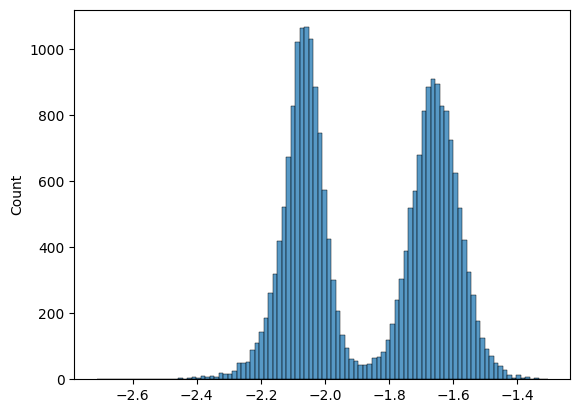

In [ ]:
import seaborn as sns

sns.histplot(psd, bins=100)

In [ ]:
hist, bin_edges = np.histogram(psd, bins=100)
indices = np.arange(len(hist))
ind_hist = np.column_stack((indices, hist))
# ind_hist
# 58, 59 -- искомые индексы бинов, где достигается минимум

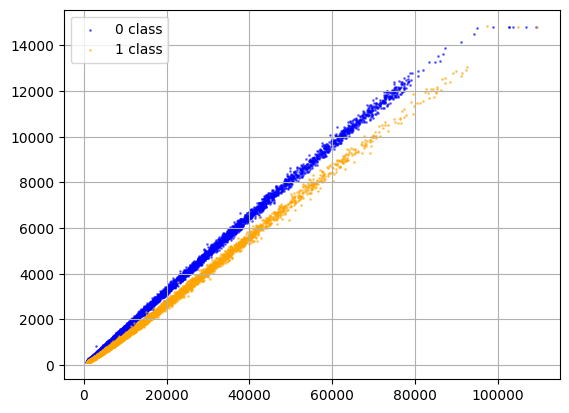

In [ ]:
threshold = (bin_edges[58] + bin_edges[59]) / 2

predic_0 = (psd < threshold).astype(int)
predic_1 = (psd >= threshold).astype(int)

plt.scatter(areas[predic_0 == 1], amps[predic_0 == 1], s=1, label='0 class', c='blue', marker='o', alpha=0.5)

plt.scatter(areas[predic_1 == 1], amps[predic_1 == 1], s=1, label='1 class', c='orange', marker='o', alpha=0.5)


plt.grid()
plt.legend()
plt.show()

In [ ]:
indices = np.where(pred_1[:, 0] != predic_1)[0]
indices.shape

(2563,)

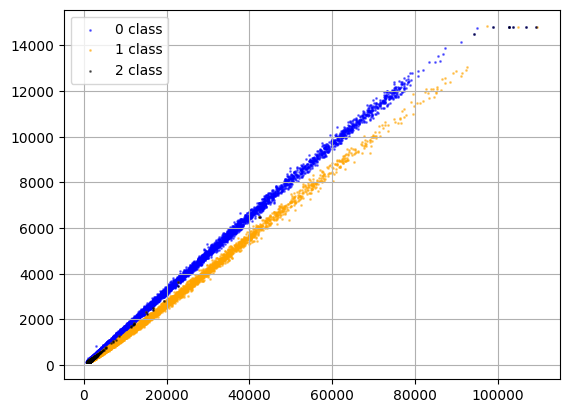

In [ ]:
plt.scatter(areas[predic_0 == 1], amps[predic_0 == 1], s=1, label='0 class', c='blue', marker='o', alpha=0.5)

plt.scatter(areas[predic_1 == 1], amps[predic_1 == 1], s=1, label='1 class', c='orange', marker='o', alpha=0.5)

plt.scatter(areas[indices], amps[indices], s=1, label='2 class', c='black', marker='o', alpha=0.5)

plt.grid()
plt.legend()
plt.show()

In [ ]:
# там где оба предсказания 1 -- один класс, оба предсказания 0 -- другой класс, там где разные -- неопределившийся (цифера 2)

indices_0 = (predic_0 + pred_0[:, 0] == 2)
indices_1 = (predic_0 + pred_0[:, 0] == 0)
indices_2 = (predic_0 + pred_0[:, 0] == 1)
print(indices_0.shape, indices_1.shape, indices_2.shape)

(23479,) (23479,) (23479,)


In [ ]:
(predic_0 + pred_0[:, 0])[0:10]

array([0, 2, 2, 0, 2, 0, 0, 1, 2, 0])

In [ ]:
index = np.arange(0, 23479)
cluster = np.zeros(23479)
cluster[indices_0] = 1
cluster[indices_1] = 0
cluster[indices_2] = 2
cluster = cluster.astype(int)

In [ ]:
cluster[0:10]

array([0, 1, 1, 0, 1, 0, 0, 2, 1, 0])

In [ ]:
ans_df = pd.DataFrame({'index': index, 'cluster': cluster})
ans_df = ans_df.sort_values(by=['cluster', 'index'])

In [ ]:
ans_df.to_csv('output.csv', index=False)

# Попробуем бахнуть KMeans

У каждого сигнала будут следующие характеристики:

angle

psd

volume и amplitude зачем-то есть, но используем мы только их отношение angle

По-сути мы используем те же 2 штуки, что и в способе выше, но разделяем их уже не ручками, а с помощью k means и при помощи их композиции, а не по отдельности. Ещё k means даёт нам понять, насколько далеко тот или иной элемент от линии разделения.

В том способе мы в теории тоже могли бы так сделать, придумать какое-то расстояние до прямой + расстояние до разделяющего PSD, но не понятно, насколько это было бы физично, а тут используется достаточно общепринятый и понятный метод. Как бы бессмысленно переизобретать kmeans


In [ ]:
psd

array([-1.64240149, -2.06503119, -2.0623264 , ..., -1.66333454,
       -1.65790249, -2.00765186])

In [ ]:
df = pd.DataFrame({'volume': areas[:, 0], 'amplitude': amps[:, 0], 'psd': psd})

In [ ]:
df['angle'] = df.apply(lambda row: row['amplitude'] / row['volume'], axis=1)

In [ ]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples

mmsc = StandardScaler()
X_scaled = mmsc.fit_transform(df[['psd', 'angle']])

kmeans = KMeans(n_clusters=2, random_state=7)

labels_kmeans = kmeans.fit_predict(X_scaled)
df['cluster'] = labels_kmeans


silhouette_avg_kmeans = silhouette_score(X_scaled, labels_kmeans)
samples = silhouette_samples(X_scaled, labels_kmeans)

print(f"KMeans: Silhouette score = {silhouette_avg_kmeans}")

KMeans: Silhouette score = 0.7265943509126342


In [ ]:
df.head(10)

,volume,amplitude,psd,angle,cluster
0,4159.5,539,-1.642401,0.129583,0
1,11815.0,1907,-2.065031,0.161405,1
2,16414.5,2566,-2.062326,0.156325,1
3,4213.0,573,-1.771167,0.136008,0
4,11453.0,1800,-2.046462,0.157164,1
5,2313.0,243,-1.607602,0.105058,0
6,6822.0,852,-1.585157,0.124890,0
7,1254.5,174,-1.706070,0.138701,0
8,12888.5,2070,-2.067834,0.160608,1
9,13120.0,1647,-1.585702,0.125534,0


In [ ]:
centers = kmeans.cluster_centers_
X = df[['psd', 'angle']]
# X.shape
# centers[labels_kmeans]
distances = np.linalg.norm(X - centers[labels_kmeans], axis=1)
distances

array([2.75187514, 1.33394856, 1.33451715, ..., 2.7757592 , 2.76774505,
       1.28714509])

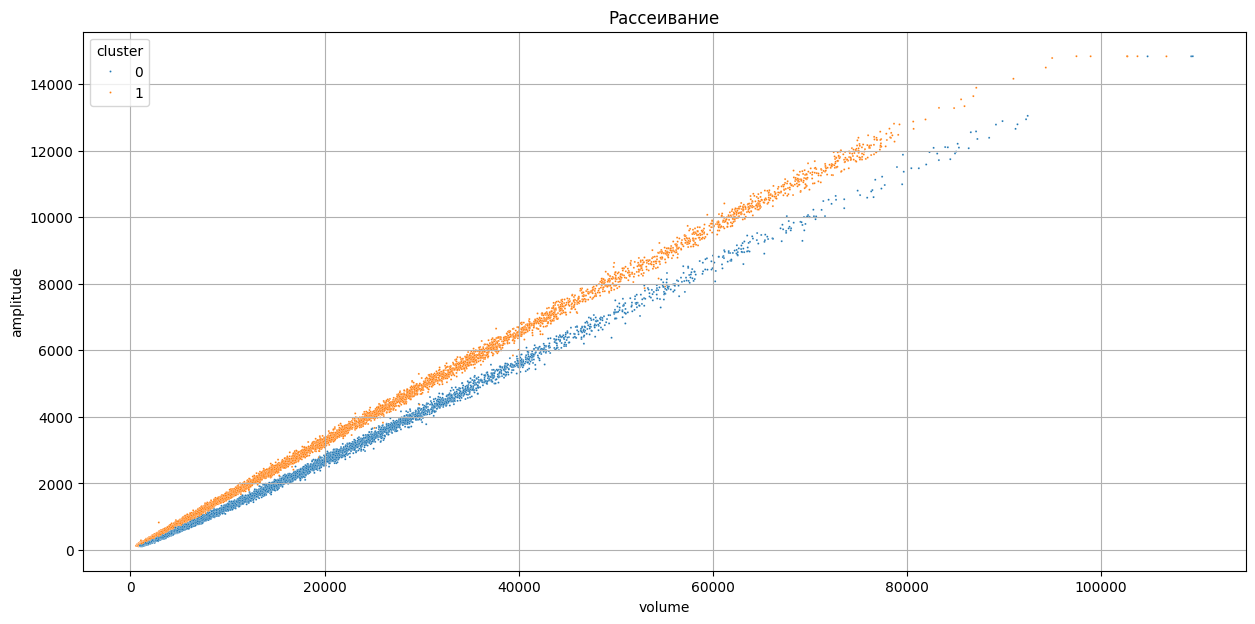

In [ ]:
plt.figure(figsize=(15, 7))
sns.scatterplot(data=df, x='volume', y='amplitude', hue='cluster', s = 2)
plt.xlabel("volume")
plt.ylabel("amplitude")
plt.title("Рассеивание")
plt.grid(True)
plt.show()

In [ ]:
lim = np.percentile(distances, 99)

top_1_percent = df[distances > lim]

df.loc[distances > lim, 'cluster'] = 2

In [ ]:
ind = np.arange(0, 23479)
clus = df['cluster'].astype(int)

df_ans = pd.DataFrame({'index': ind, 'cluster': clus})
df_ans = df_ans.sort_values(by=['cluster', 'index'])

In [ ]:
df_ans.to_csv('output_kmeans.csv', index=False)

если сделать 98% и 99.5%, получается одинаковый результат, чуть худший чем при 99%. Значит нам надо определить как 2 класс 1.25% по-сути. Но 1% всё ещё лучше. Если идти в сторону уменьшения, там хуже.